In [1]:
#import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
#from conviction_helpers import *
#from conviction_system_logic3 import *
from bonding_curve_eq import *

System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .5 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
F0 = hatch_raise*theta
S0 = hatch_raise/hatch_price

kappa = 2
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

dust = 10**-8

agent initialization

In [3]:
#number of agents
n= 100

#gain factors
g = np.random.normal(2, .5, size=n)
phat0 = g*F0/S0 #derivative, integral and proportion
#agents as controllers, co-steering

#wakeup rates
gamma =  sts.expon.rvs(loc=1,scale=5, size=n)

#holdings fiat
h = sts.expon.rvs( loc=100,scale=1000, size=n)

#holdings tokens
s_dist = sts.expon.rvs(loc=10, scale=10, size=n)
s0 = s_dist/sum(s_dist)*S0

#lambda for revenue process
lam = 200

#phi for exiting funds
phi = .05

#beta is param for armijo rule
beta = .9

(array([34., 26.,  9., 14.,  6.,  2.,  5.,  1.,  1.,  2.]),
 array([ 1.08275068,  3.04308878,  5.00342687,  6.96376497,  8.92410307,
        10.88444117, 12.84477927, 14.80511736, 16.76545546, 18.72579356,
        20.68613166]),
 <a list of 10 Patch objects>)

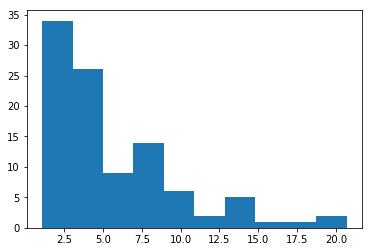

In [4]:
plt.hist(gamma)

In [5]:
params= {
    'kappa': [kappa],
    'lambda': [lam],
    'gains': [g],
    'rates':[1/gamma],
    'population':[n],
    'beta':[beta],
    'phi': [phi],
    'invariant': [V0],
    'dust' : [dust]}

In [6]:
initial_conditions = {'holdings': h,
                      'tokens': s0,
                      'supply': S0,
                      'prices': phat0,
                      'funds':F0,
                      'reserve': R0,
                      'spot_price': P0,
                      'actions': {}}

In [7]:
initial_conditions

{'actions': {},
 'funds': 50000.0,
 'holdings': array([1381.81065484,  503.6421824 , 1733.23237835,  458.02194035,
        1706.46225568,  853.70697172,  182.49819741, 2995.59667896,
         822.16382629,  817.14190299,  881.79605743,  730.53715879,
         116.19339824, 1309.95958537,  320.56264777, 5724.38540714,
         503.91742415, 2943.20729819,  513.27959567, 2445.70269028,
         924.58820267,  208.09101348,  857.4889706 , 1471.15499747,
        1763.76064489, 1115.67060044,  389.318447  , 4425.49943663,
         139.81127818,  706.08557629,  778.50055115,  173.56589587,
         334.36011272, 1296.45045381,  335.12823218,  240.75442822,
        1101.81670675,  558.43391288,  496.12354716, 2516.78800005,
        2189.24226166, 1063.22712387,  962.43232271,  459.12366463,
        1797.46902454, 2334.30370876,  372.86359938,  333.87271775,
         522.88075376,  872.79251341,  355.51011185,  404.73901018,
         572.72101236, 2189.89651087, 1103.17268324,  502.77697018,
 

In [8]:
#change in F (revenue and spending accounted for)
def revenue_process(params, step, sL, s):
    lam = params['lambda']
    rv = sts.expon.rvs(loc = 0, scale=1/lam)
    delF= 1-1/lam+rv
    
    #avoid the crash (temporary hacks, tune martingale process better)
    #if delF <1:
    #    if s['funds'] <1000:
    #        delF =100
    
    return({'delF':delF})

In [9]:
def update_funds(params, step, sL, s, _input):
    
    funds = s['funds']*_input['delF']
    
    key = 'funds'
    value = funds
    
    return (key, value)

In [10]:
def update_prices(params, step, sL, s, _input):
    
    g = params['gains']
    phat = g*s['funds']/s['supply']
    
    key = 'prices'
    value = phat
    
    return (key, value)

In [11]:
#change in F (revenue and spending accounted for)
def choose_agents(params, step, sL, s):
    n = params['population']
    rates = params['rates']
    
    agents = []
    for a in range(n):
        sq_gap = (s['spot_price']-s['prices'][a])**2
        pr = (rates[a]+sq_gap)/(1+sq_gap) #rates when sq_gap =0, 1 when sq_gap -> infty
        rv = np.random.rand()
        if rv < pr:
            agents.append(a)
    
    #shuffle
    shuffled_agents =np.random.choice(agents,len(agents), False)     
        
    return({'agents':shuffled_agents})

In [12]:
def agent_actions(params, step, sL, s, _input):
    
    R = s['reserve']
    S = s['supply']
    F = s['funds']
    V0 = params['invariant']
    P=s['spot_price']
    
    actions = []
    for a in _input['agents']:
        h_a = s['holdings'][a]
        phat_a = s['prices'][a]
        s_a =  s['tokens'][a]
        beta = params['beta']

        if P>phat_a: #equiv: pbar(0)>phat_a
            mech = 'burn'
                        
            #approx for burn s.t. p=phat
            #armijo style
            amt = s_a
            
            def pbar(amt):
                output = withdraw_with_tax(amt, R,S, V0, params['phi'], params['kappa'])

                if not(output[2])>0:
                    return np.Infinity
                else:
                    return output[2]

            if amt > 10**-8:
                while pbar(amt)< phat_a:
                    amt = amt*beta

        else: # P<phat_a; #equiv pbar(0)<phat_a
            mech = 'bond'
            #approx for buy s.t. p=phat
            #armijo style
            amt = h_a
  
            def pbar(amt):
                output = mint(amt, R,S, V0, params['kappa'])

                if not(output[1])>0:
                    return 0
                else:
                    return output[1]
                
            if amt > params['dust']:
                while pbar(amt)> phat_a:
                    amt = amt*beta
        
        action = {'agent':a, 'mech':mech, 'amt':amt, 'pbar':pbar(amt),'posterior':{}}
        
        if action['mech'] == 'bond':
            h_a = h_a-amt
            dS, pbar = mint(amt, R,S, V0, params['kappa'])
            R = R+amt
            S = S+dS
            s_a = s_a+dS
            P = spot_price(R, V0, kappa)
    
        elif action['mech'] == 'burn':
            s_a = s_a-amt
            dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
            R = R-dR
            F = F + params['phi']*dR
            S = S-amt
            h_a = h_a + (1-params['phi'])*dR
            P = spot_price(R, V0, kappa)
        
        action['posterior'] = {'F':F, 'S':S, 'R':R,'P':P, 'a':a,'s_a':s_a, 'h_a':h_a}
        actions.append(action)
        
    key = 'actions'
    value = actions
    
    return (key, value)

In [13]:
def resolve_actions(params, step, sL, s):
    
    H_a = s['holdings']
    S_a =  s['tokens']
    
    actions = s['actions']
    
    for action in actions:
        a= action['agent']
        H_a[a] = action['posterior']['h_a']
        S_a[a] = action['posterior']['s_a']
    
    #last action only
    F = action['posterior']['F']
    R = action['posterior']['R']
    P = action['posterior']['P']
    S = action['posterior']['S']
    
    return({'F':F, 'S':S, 'R':R,'P':P, 'S_a':S_a, 'H_a':H_a})

In [14]:
def update_F(params, step, sL, s, _input):
    
    F = _input['F']
    
    key = 'funds'
    value = F
    
    return (key, value)

def update_S(params, step, sL, s, _input):
    
    S = _input['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    R = _input['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    P = _input['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_holdings(params, step, sL, s, _input):
    
    H_a = _input['H_a']
    
    key = 'holdings'
    value = H_a
    
    return (key, value)

def update_tokens(params, step, sL, s, _input):
    
    S_a = _input['S_a']
    
    sumS = np.sum(S_a)
    S = _input['S']
    
    tokens = S_a*S/sumS
    
    key = 'tokens'
    value = tokens
    
    return (key, value)

In [15]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': revenue_process
        },
        'variables': {
            'funds': update_funds,
            'prices': update_prices
        }
    },
    {
      'policies': {
          'random': choose_agents
        },
        'variables': { 
            'actions': agent_actions, 
        }
    },
    {
      'policies': {
          'act': resolve_actions,
        },
        'variables': {
            'funds': update_F, #
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'holdings': update_holdings,
            'tokens': update_tokens
        }
    }
]

In [16]:
time_periods_per_run = 1000
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [17]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 1000), 'M': {'kappa': 2, 'lambda': 200, 'gains': array([2.2921666 , 1.98818595, 1.99997495, 2.61700232, 1.47518894,
       2.51351361, 1.51605356, 1.66782316, 2.46935463, 0.97358694,
       2.19041391, 2.9362623 , 2.25426095, 1.81905155, 2.03085349,
       1.96126515, 2.39370876, 2.24935254, 2.38912398, 2.15492905,
       1.60462071, 1.22979399, 2.36695694, 2.05161337, 1.55974821,
       2.17566063, 1.54377836, 3.35493869, 1.49586875, 2.33145561,
       2.32299809, 2.39795069, 2.34849001, 1.74285357, 2.10702026,
       2.55821851, 1.6497427 , 1.39102242, 1.91930368, 2.61147596,
       2.84844282, 2.29384739, 1.59352497, 2.7105475 , 1.87447698,
       1.93270526, 2.21992251, 1.39516659, 2.57506325, 2.0339276 ,
       2.43301018, 1.34371915, 1.90269332, 1.58239104, 1.88624816,
       1.11486924, 2.7721075 , 1.66598127, 0.88505501, 1.58447293,
       1.50460689, 1.91009698, 1.92902333, 2.61110437, 2.34350311,
       1.46404661, 2.17210079, 2.74378223, 2.0553947 , 2

In [18]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [19]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a1506e5f8>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a1506e5f8>]


/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:37: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = deltaR/deltaS


In [20]:
experiment_index = 0
df = results[experiment_index]['result']

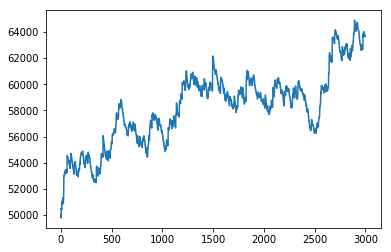

In [21]:
df.funds.plot()

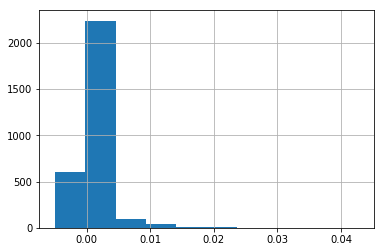

In [22]:
(df.funds.diff()/df.funds).hist()

In [23]:
rdf = df[df.substep == 3].copy()

In [24]:
rdf['token_wts'] = (rdf.tokens/rdf.supply)
rdf['wt_mean_price'] = (rdf.token_wts*rdf.prices).apply(sum)

In [25]:
rdf['holding_wts'] = (rdf.holdings/rdf.holdings.apply(sum))
rdf['h_wt_mean_price'] = (rdf.holding_wts*rdf.prices).apply(sum)

In [26]:
rdf['wealth'] = rdf.holdings + rdf.spot_price*rdf.tokens

In [27]:
rdf['wealth_wts'] = rdf.wealth/rdf.wealth.apply(sum)
rdf['w_wt_mean_price'] = (rdf.wealth_wts*rdf.prices).apply(sum)

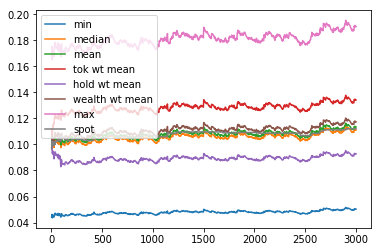

In [28]:
rdf.prices.apply(np.min).plot()
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.prices.apply(np.max).plot()
rdf.spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

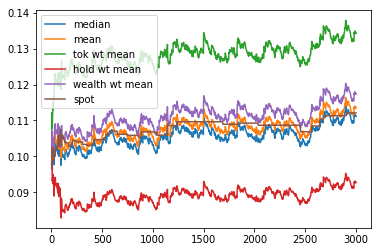

In [29]:
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.spot_price.plot()
plt.legend(['median','mean','tok wt mean','hold wt mean','wealth wt mean', 'spot'])

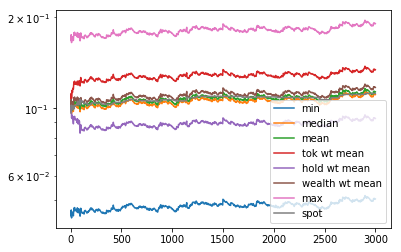

In [30]:
rdf.prices.apply(np.min).plot(logy=True)
rdf.prices.apply(np.median).plot(logy=True)
rdf.prices.apply(np.mean).plot(logy=True)
rdf.wt_mean_price.plot(logy=True)
rdf.h_wt_mean_price.plot(logy=True)
rdf.w_wt_mean_price.plot(logy=True)
rdf.prices.apply(np.max).plot(logy=True)
rdf.spot_price.plot(logy=True)
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [31]:
rdf['median_price']=rdf.prices.apply(np.median)
rdf['mean_price']=rdf.prices.apply(np.mean)

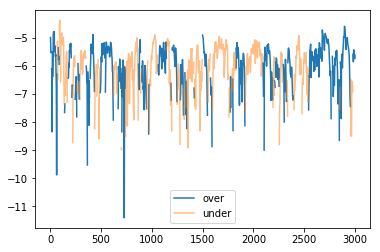

In [32]:
(np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=1)
(-np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=.5)
plt.legend(['over','under'])

In [33]:
rdf['est_err'] = rdf.spot_price - rdf.wt_mean_price
rdf['sq_est_err'] = rdf['est_err']**2

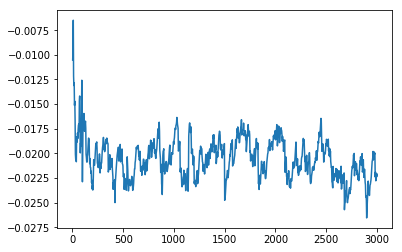

In [34]:
rdf.est_err.plot()

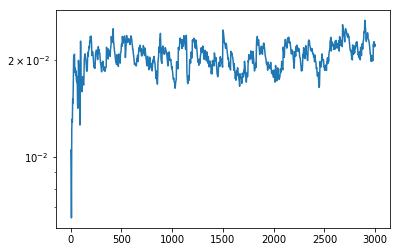

In [35]:
rdf.est_err.apply(np.abs).plot(logy=True)

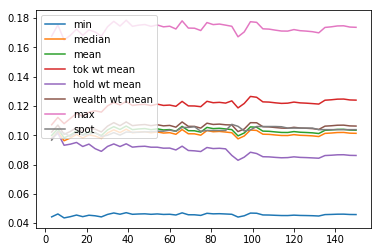

In [36]:
#head T
T = 50
rdf.head(T).prices.apply(np.min).plot()
rdf.head(T).prices.apply(np.median).plot()
rdf.head(T).prices.apply(np.mean).plot()
rdf.head(T).wt_mean_price.plot()
rdf.head(T).h_wt_mean_price.plot()
rdf.head(T).w_wt_mean_price.plot()
rdf.head(T).prices.apply(np.max).plot()
rdf.head(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

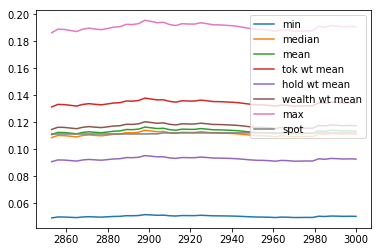

In [37]:
T = 50
rdf.tail(T).prices.apply(np.min).plot()
rdf.tail(T).prices.apply(np.median).plot()
rdf.tail(T).prices.apply(np.mean).plot()
rdf.tail(T).wt_mean_price.plot()
rdf.tail(T).h_wt_mean_price.plot()
rdf.tail(T).w_wt_mean_price.plot()
rdf.tail(T).prices.apply(np.max).plot()
rdf.tail(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [38]:
tx_data = rdf.actions.values
transactions = []
states = []
for t in range(time_periods_per_run):
    for tx in range(len(tx_data[t])):
        states.append(tx_data[t][tx]['posterior'])
        transactions.append(tx_data[t][tx])


In [39]:
sdf = pd.DataFrame(states)
tdf = pd.DataFrame(transactions).drop('posterior', axis=1)

In [40]:
ind=tdf[tdf.amt==0].index
tdf.drop(ind, inplace=True)
sdf.drop(ind, inplace=True)

In [41]:
txdf = sdf.merge(tdf, right_index=True, left_index=True)

In [42]:
txdf.head()

,F,P,R,S,a,h_a,s_a,agent,amt,mech,pbar
0,49868.738051,0.098338,48351.484524,983376.677820,60,3825.580705,0.000000,60,1.662332e+04,burn,0.094210
1,49868.738051,0.098678,48686.612756,986778.726525,34,0.000000,10127.989823,34,3.351282e+02,bond,0.098508
2,49868.738051,0.098678,48686.612756,986778.726525,89,1008.763267,10820.075298,89,1.500982e-09,burn,0.096707
3,49915.936387,0.097717,47742.646027,977165.758990,59,1146.524288,0.000000,59,9.612968e+03,burn,0.093287
4,49986.129937,0.096269,46338.775022,962691.799295,20,2258.265658,0.000000,20,1.447396e+04,burn,0.092143


In [43]:
emas = ['P', 'pbar']
for com in [2,4,8,16]:
    k = 'pbar_ewma'+str(com)
    emas.append(k)
    txdf[k] = txdf.pbar.ewm(com).mean()

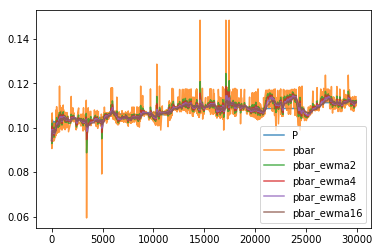

In [44]:
txdf[emas].plot(alpha=.8)

[0, 3000, 0.095, 0.115]

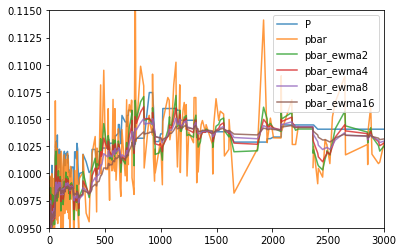

In [45]:
txdf[emas].plot(alpha=.8)
plt.axis([0, 3000, .095, .115])

In [46]:
tx_summary=tdf[['agent','mech','pbar','amt']].groupby(['agent','mech']).agg(['median','count']).T.iloc[:-1].T

In [47]:
tx_summary

pbar                  amt
              median  count        median
agent mech                               
0     bond  0.101549    1.0  1.381811e+03
1     bond  0.106027   19.0  5.737093e-10
      burn  0.109251   74.0  1.518447e-09
2     bond  0.107529   18.0  3.075911e-10
      burn  0.109361   57.0  8.216649e-10
3     bond  0.101784    1.0  4.580219e+02
4     burn  0.092839    1.0  9.969567e+03
5     bond  0.102752    1.0  8.537070e+02
6     burn  0.097383    1.0  5.270248e+03
7     burn  0.093518    1.0  8.283756e+03
8     bond  0.104104    1.0  8.221638e+02
9     burn  0.093529    1.0  5.490232e+03
10    bond  0.097491    1.0  8.817961e+02
11    bond  0.097601    1.0  7.305372e+02
12    bond  0.098165    1.0  1.161934e+02
13    burn  0.096354    1.0  6.881779e+03
14    bond  0.106875    5.0  1.935405e-10
      burn  0.109564    6.0  1.766455e-09
15    bond  0.105688   12.0  6.775428e+01
      burn  0.107188  104.0  1.347808e-09
16    bond  0.105579    1.0  5.039174e+02
17    bond  0.099902    1.0  2.943207e+03
18    bond  0.099571    1.0  5.132796e+02
19    bond  0.104804    1.0  2.445703e+03
20    burn  0.092143    1.0  1.447396e+04
21    burn  0.095243    1.0  6.644187e+03
22    bond  0.101748    1.0  8.574890e+02
23    bond  0.108854    7.0  1.382432e-10
      burn  0.106981   10.0  1.098385e-09
24    burn  0.092926    1.0  7.208115e+03
...              ...    ...           ...
74    burn  0.092635    1.0  1.690894e+04
75    bond  0.097785    1.0  5.397786e+02
76    bond  0.104822    1.0  1.086099e+03
77    bond  0.104391    4.0  6.393748e-10
      burn  0.108150    5.0  1.533906e-09
78    burn  0.096461    1.0  1.344499e+04
79    burn  0.095844    1.0  1.534129e+04
80    bond  0.100801    1.0  5.608792e+02
81    bond  0.100332    2.0  3.352715e+02
      burn  0.109134    1.0  6.333665e-10
82    burn  0.096266    1.0  1.672999e+04
83    burn  0.104053   20.0  2.446912e-09
84    burn  0.093643    1.0  9.305744e+03
85    bond  0.101101    1.0  4.563242e+02
86    bond  0.108909   16.0  2.393736e+02
      burn  0.106566  418.0  2.084695e-09
87    burn  0.096304    1.0  7.150801e+03
88    burn  0.096551    1.0  7.520997e+03
89    burn  0.098072    5.0  1.350884e-09
90    burn  0.094263    1.0  7.409782e+03
91    burn  0.095553    1.0  9.975654e+03
92    burn  0.092879    1.0  5.162859e+03
93    burn  0.090638    1.0  1.304687e+04
94    burn  0.095392    3.0  1.102470e+03
95    burn  0.094583    1.0  1.049481e+04
96    burn  0.094995    1.0  6.004215e+03
97    bond  0.100298    1.0  3.394536e+03
98    bond  0.105450   10.0  6.448575e+02
      burn  0.106684  158.0  1.542172e-09
99    burn  0.096315    1.0  1.301649e+04

[117 rows x 3 columns]

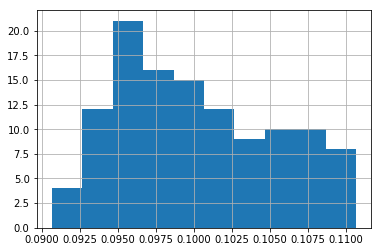

In [48]:
tx_summary.pbar['median'].hist()

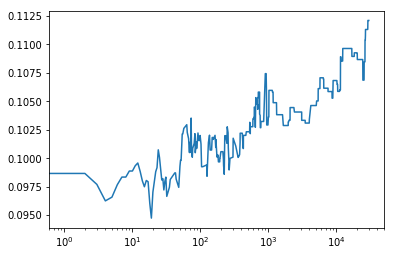

In [49]:
sdf['P'].plot(logx=True)

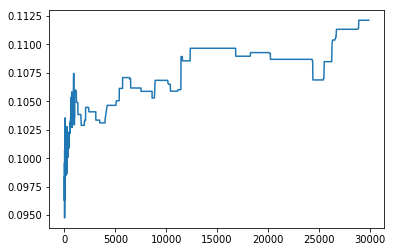

In [50]:
sdf['P'].plot()

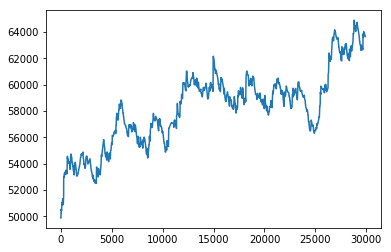

In [51]:
sdf.F.plot()

In [52]:
bond_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='bond']
burn_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='burn']

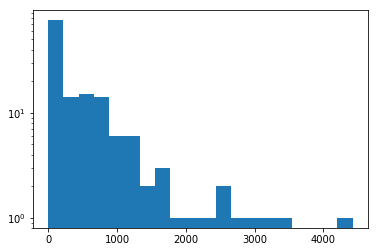

In [53]:
plt.hist(bond_amts, bins=20)
plt.yscale('log')

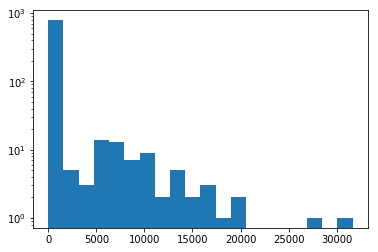

In [54]:
plt.hist(burn_amts, bins=20)
plt.yscale('log')

In [55]:
rdf['invariant'] = rdf.supply.apply(lambda x: x**kappa)/rdf.reserve

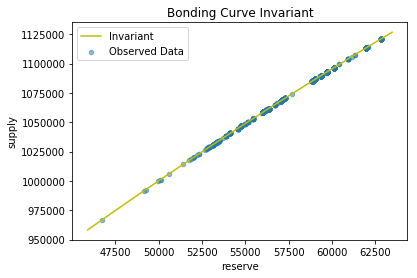

In [56]:
rdf.plot(x='reserve', y='supply', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([supply(x, V0, kappa) for x in xrange ])
plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Invariant')
plt.legend(['Invariant', 'Observed Data'])

In [57]:
def gini(x):

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

(array([52.,  2., 10.,  8., 10., 10.,  2.,  2.,  2.,  2.]),
 array([   0.        ,  382.55807046,  765.11614092, 1147.67421137,
        1530.23228183, 1912.79035229, 2295.34842275, 2677.9064932 ,
        3060.46456366, 3443.02263412, 3825.58070458]),
 <a list of 10 Patch objects>)

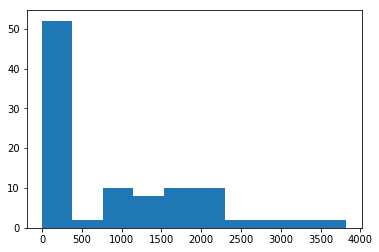

In [58]:
plt.hist(rdf.iloc[-1].holdings)

In [59]:
rdf['gini_h'] = rdf.holdings.apply(gini)

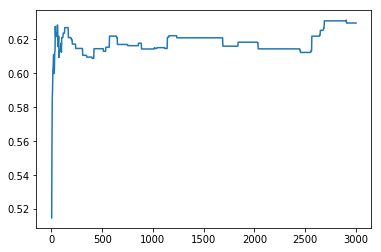

In [60]:
rdf.gini_h.plot()

(array([48., 18., 14.,  9.,  8.,  0.,  1.,  1.,  0.,  1.]),
 array([    0.        ,  7192.42112159, 14384.84224317, 21577.26336476,
        28769.68448635, 35962.10560793, 43154.52672952, 50346.94785111,
        57539.36897269, 64731.79009428, 71924.21121587]),
 <a list of 10 Patch objects>)

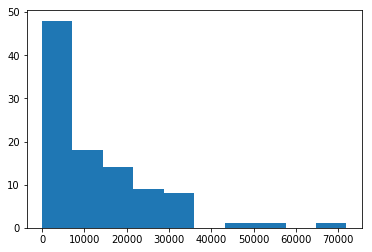

In [61]:
plt.hist(rdf.iloc[-1].tokens)

In [62]:
rdf['gini_s'] = rdf.tokens.apply(gini)

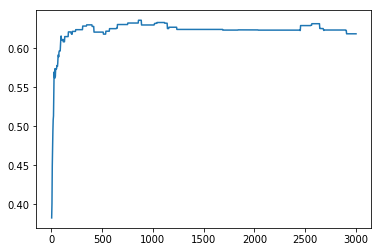

In [63]:
rdf.gini_s.plot()

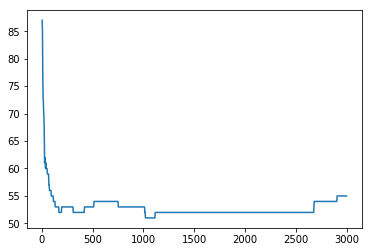

In [64]:
rdf.tokens.apply(np.count_nonzero).plot()

In [65]:
rdf['asset_value'] = rdf.holdings + rdf.spot_price*rdf.tokens

(array([32., 34., 16., 10.,  5.,  1.,  0.,  1.,  0.,  1.]),
 array([ 683.78753094, 1421.73923066, 2159.69093039, 2897.64263011,
        3635.59432983, 4373.54602955, 5111.49772928, 5849.449429  ,
        6587.40112872, 7325.35282844, 8063.30452816]),
 <a list of 10 Patch objects>)

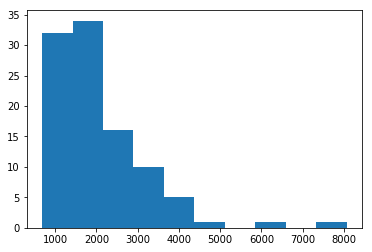

In [66]:
plt.hist(rdf.iloc[-1].asset_value)

In [67]:
rdf['gini'] = rdf.asset_value.apply(gini)

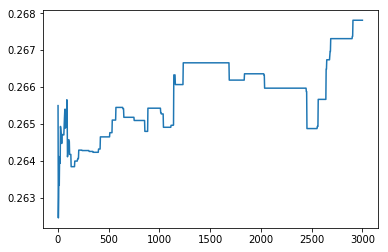

In [68]:
rdf.gini.plot()

In [69]:
rdf['pref_gap'] = (rdf.prices - rdf.spot_price)/rdf.spot_price

([array([ 5., 15., 28., 25., 20.,  6.,  1.]),
  array([ 5., 16., 29., 23., 20.,  6.,  1.]),
  array([ 5., 15., 28., 25., 20.,  6.,  1.]),
  array([ 5., 15., 28., 25., 20.,  6.,  1.]),
  array([ 5., 16., 28., 24., 20.,  6.,  1.]),
  array([ 5., 15., 28., 25., 20.,  6.,  1.]),
  array([ 5., 16., 28., 24., 20.,  6.,  1.])],
 array([-0.55218258, -0.37203459, -0.1918866 , -0.01173861,  0.16840938,
         0.34855737,  0.52870537,  0.70885336]),
 <a list of 7 Lists of Patches objects>)

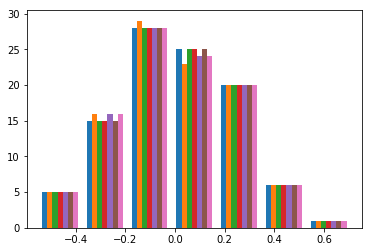

In [70]:
plt.hist(rdf.iloc[-7:].pref_gap, bins=7)